<a href="https://colab.research.google.com/github/LanaSina/lpf_upper/blob/gpu/lpf_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running LPF on colab

Original code: https://github.com/cxinsys/lpf

Paper: https://academic.oup.com/bioinformatics/article/39/7/btad430/7221539

Just run all cells and get a ladybug.

## Setup

Pull code

In [1]:
!git clone https://github.com/LanaSina/lpf_upper.git

Cloning into 'lpf_upper'...
remote: Enumerating objects: 2205, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 2205 (delta 34), reused 13 (delta 5), pack-reused 2142
Receiving objects: 100% (2205/2205), 36.22 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (1447/1447), done.


Install LPF

In [2]:
!python "lpf_upper/setup.py" install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [3]:
%pwd
%ls
%cd lpf_upper
!pip install -r requirements.txt

build/  dist/  lpf.egg-info/  lpf_upper/  sample_data/
/content/lpf_upper
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.8 MB/s eta 0:00:00


Install PyGMO

In [4]:
!pip install pygmo
!pip install torchmetrics
# order matters!
!pip install lpips
!pip install torchmetrics[image]
#-c conda-forge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.5 MB/s eta 0:00:00


## Learn parameters from photo

!! Warning !! Make this session GPU if using this tutorial.

In [5]:
import os
import os.path as osp
import time

import numpy as np
import pygmo as pg
from PIL import Image

from lpf.data import load_model_dicts
from lpf.data import load_custom_targets
from lpf.solvers import SolverFactory
from lpf.search import EvoSearch
from lpf.objectives import ObjectiveFactory
from lpf.models import ModelFactory
from lpf.converters import ConverterFactory

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:671: ImportWarning: _OpenCVImportHook.exec_module() not found; falling back to load_module()
<frozen importlib._bootstrap>:632: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/local/lib/python3.10/dist-packages/cv2/cv2.abi3.so'>
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling bac

In [6]:
LPF_REPO_HOME = osp.join(osp.abspath(".."), "lpf_upper")
LPF_REPO_HOME

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/content/lpf_upper'

In [7]:
# Create a model.
dx = 0.1
width = 128
height = 128
n_init_pts = 25

model = ModelFactory.create(
    name="Liaw",
    n_init_pts=n_init_pts,
    width=width,
    height=height,
    dx=dx
)

In [8]:
# Create a solver.
dt = 0.01
n_iters = 500000
solver = SolverFactory.create(name="Euler", dt=dt, n_iters=n_iters)

In [9]:
# Create a converter.
converter = ConverterFactory.create("LiawInitializer")

In [10]:
# Create objectives.
obj_config = [
    ['MeanMeanSquareError', '1e-1', 'cpu'], #cpu
    ['MeanColorProportion', '1e0', 'cpu'], #cpu
    ['MeanVgg16PerceptualLoss', '1e-4', 'cuda:0'], #cuda:0
    ['MeanLearnedPerceptualImagePatchSimilarity:vgg', '1.5e1', 'cuda:0'], #cuda:0
    ['MeanLearnedPerceptualImagePatchSimilarity:alex', '4e0', 'cuda:0']  #cuda:0
]

# todo change conf to gpu

objectives = ObjectiveFactory.create(obj_config)

[OBJECTIVE DEVICE] MeanMeanSquareError: cpu
[OBJECTIVE DEVICE] MeanColorProportion: cpu
[OBJECTIVE DEVICE] MeanVgg16PerceptualLoss: cuda:0


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 237MB/s]


[OBJECTIVE DEVICE] MeanLearnedPerceptualImagePatchSimilarity:vgg: cuda:0
[OBJECTIVE DEVICE] MeanLearnedPerceptualImagePatchSimilarity:alex: cuda:0


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 288MB/s]


[TARGET] spectabilis02.png has been added...


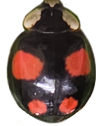

In [11]:
# Load the target laybirds.
targets = load_custom_targets("lpf/data/haxyridis/photo", "spectabilis")

for img in targets:
    display(img)


In [12]:
# Create an evolutionary search problem.
droot_output = osp.join("./output")

search = EvoSearch(model=model,
                   solver=solver,
                   converter=converter,
                   targets=targets,
                   objectives=objectives,
                   droot_output=droot_output)

prob = pg.problem(search)

In [13]:
print(droot_output)

./output


In [14]:
dpath_init_pop = osp.join(LPF_REPO_HOME, "population", "init_pop_axyridis")
model_dicts = load_model_dicts(dpath_init_pop)

In [ ]:
t_beg = time.time()

# Create the initial population.
pop_size = 16  # We set population size = 16.
pop = pg.population(prob)
dvs = []

# Initialize the population with axyridis subtype.
for i, param_dict in enumerate(model_dicts):
    if i >= pop_size:
        break

    dv = converter.to_dv(param_dict, n_init_pts)
    dvs.append(dv)

# Adding decision vectors incorporates evaluating the fitness score.
for i, dv in enumerate(dvs):
    print(f"[DECISION VECTOR #{i+1}]\n", dv)

    # pop.set_x(i, dv)
    pop.push_back(dv)

# end of for

t_end = time.time()

print("[POPULATION INITIALIZATION COMPLETED]")
print("- DURATION OF INITIALIZING POPULATION: %.3f sec."%(t_end - t_beg))
print(pop)

In [210]:
# Create an evolutionary algorithm.
n_procs = 8
n_gen = 10000

udi = pg.mp_island()
udi.resize_pool(n_procs)

algo = pg.algorithm(pg.sade(gen=1))
isl = pg.island(algo=algo, pop=pop, udi=udi)
print(isl)

Island name: Multiprocessing island
	C++ class name: pybind11::object

	Status: idle

Extra info:
	Using a process pool: yes
	Number of processes in the pool: 8

Algorithm: saDE: Self-adaptive Differential Evolution

Problem: <class 'lpf.search.evosearch.EvoSearch'>

Replacement policy: Fair replace

Selection policy: Select best

Population size: 16
	Champion decision vector: [-3.30103, -1.12494, -0.744727, -1.55253, -0.69897, ... ]
	Champion fitness: [17.4923]



### debug

In [ ]:
!pip freeze

In [47]:
isl_test = pg.island(algo = pg.de(10), prob = pg.ackley(5), size=20, udi=pg.thread_island())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
isl_test.evolve()

In [54]:
isl_test.wait_check()
print(isl_test)

Island name: Thread island
	C++ class name: pagmo::thread_island

	Status: idle

Extra info:
	Using pool: yes

Algorithm: DE: Differential Evolution

Problem: Ackley Function

Replacement policy: Fair replace

Selection policy: Select best

Population size: 20
	Champion decision vector: [-1.06592, 4.95717, -1.09255, 3.59578, -2.5848]
	Champion fitness: [10.6228]



In [56]:
print(isl)
isl.wait_check()

Island name: Multiprocessing island
	C++ class name: pybind11::object

	Status: idle

Extra info:
	Using a process pool: yes
	Number of processes in the pool: 2

Algorithm: saDE: Self-adaptive Differential Evolution

Problem: <class 'lpf.search.evosearch.EvoSearch'>

Replacement policy: Fair replace

Selection policy: Select best

Population size: 16
	Champion decision vector: [-3.30103, -1.12494, -0.744727, -1.55253, -0.69897, ... ]
	Champion fitness: [17.4923]



In [70]:

from importlib import util

util.find_spec("lpf")

ModuleSpec(name='lpf', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f6123a22b60>, origin='/content/lpf_upper/lpf/__init__.py', submodule_search_locations=['/content/lpf_upper/lpf'])

In [67]:
# if has_dill:
# from dill import dumps, loads
    # else:
from pickle import dumps, loads
    # algo, pop = loads(ser_algo_pop)

algo = pg.algorithm(pg.sade(gen=1))
prob = pg.ackley(5)

loads(pop)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: ignored

In [189]:
# migrate something (?) for pickle
import lpf
sys.modules['lpf'] = lpf

print(sys.modules)

{'sys': <module 'sys' (built-in)>, 'builtins': <module 'builtins' (built-in)>, '_frozen_importlib': <module '_frozen_importlib' (frozen)>, '_imp': <module '_imp' (built-in)>, '_thread': <module '_thread' (built-in)>, '_warnings': <module '_warnings' (built-in)>, '_weakref': <module '_weakref' (built-in)>, '_io': <module '_io' (built-in)>, 'marshal': <module 'marshal' (built-in)>, 'posix': <module 'posix' (built-in)>, '_frozen_importlib_external': <module '_frozen_importlib_external' (frozen)>, 'time': <module 'time' (built-in)>, 'zipimport': <module 'zipimport' (frozen)>, '_codecs': <module '_codecs' (built-in)>, 'codecs': <module 'codecs' from '/usr/lib/python3.10/codecs.py'>, 'encodings.aliases': <module 'encodings.aliases' from '/usr/lib/python3.10/encodings/aliases.py'>, 'encodings': <module 'encodings' from '/usr/lib/python3.10/encodings/__init__.py'>, 'encodings.utf_8': <module 'encodings.utf_8' from '/usr/lib/python3.10/encodings/utf_8.py'>, '_signal': <module '_signal' (built-i

In [200]:
# from pygmo import py_islands

import pygmo
from pickle import dumps, loads


ser_algo_pop = dumps((algo, pop))
algo, pop = loads(ser_algo_pop)


# pygmo.ipyparallel_island._evolve_func_mp_pool(ser_algo_pop)

In [17]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:85: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/dill-0.3.7.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [208]:
import locale

encoding = locale.getpreferredencoding()

In [15]:
import _locale
_locale._getdefaultlocale = (lambda *args: ['en_US', 'utf8'])

In [18]:
import dill

### continue

end debug

In [ ]:
# todo move above
!pip install dill

In [209]:
# Sub-directories in the output directory
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {dpath_output}

model_1  models


In [205]:
# Start searching.
try:
    for i in range(n_gen):
        t_beg = time.time()
        isl.evolve()
        isl.wait_check()
        t_end = time.time()

        print("[EVOLUTION #%d] Best objective: %f (%.3f sec.)"%(i + 1, pop.champion_f[0], t_end - t_beg))

        # Save the best.
        pop = isl.get_population()
        search.save("best", pop.champion_x, generation=i+1, fitness=pop.champion_f[0])

        # Save the population.
        arr_x = pop.get_x()
        arr_f = pop.get_f()
        for j in range(arr_x.shape[0]):
            x = arr_x[j]
            fitness = arr_f[j, 0]
            search.save("pop", x, generation=i+1, fitness=fitness)
    # end of for
except Exception as err:
    print(err)
    udi.shutdown_pool()
    raise err


print("[EVOLUTIONARY SEARCH COMPLETED]")
udi.shutdown_pool()

The asynchronous evolution of a pythonic island of type 'Multiprocessing island' raised an error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pygmo/_py_islands.py", line 222, in run_evolve
    import dill
  File "/usr/local/lib/python3.10/dist-packages/dill/__init__.py", line 26, in <module>
    from ._dill import (
  File "/usr/local/lib/python3.10/dist-packages/dill/_dill.py", line 168, in <module>
    PyTextWrapperType = get_file_type('r', buffering=-1, open=_open)
  File "/usr/local/lib/python3.10/dist-packages/dill/_dill.py", line 156, in get_file_type
    f = open(os.devnull, *args, **kwargs)
  File "/usr/lib/python3.10/_pyio.py", line 282, in open
    text = TextIOWrapper(buffer, encoding, errors, newline, line_buffering)
  File "/usr/lib/python3.10/_pyio.py", line 2045, in __init__
    encoding = locale.getpreferredencoding(False)
TypeError: <lambda>() takes 0 positional arguments but 1 was given



RuntimeError: ignored

In [ ]:
# try

## Solve one parameter set

From: Tutorial 1

In [103]:
import os
import os.path as osp
from os.path import join as pjoin
import time
from datetime import datetime
import json

import numpy as np
np.seterr(all='raise')
from PIL import Image

from lpf.initializers import LiawInitializer
from lpf.models import LiawModel
from lpf.solvers import EulerSolver, RungeKuttaSolver

In [167]:
batch_size = 1  # A single set of parameters
device = "cpu" # cpu is usually much faster here # Device option: CPU or GPU

# Time parameters
dt = 0.01
n_iters = 50000 #500000

# Space parameters
dx = 0.1
width = 128
height = 128
shape = (height, width)

In [168]:
# Create the output directory.
str_now = datetime.now().strftime('%Y%m%d-%H%M%S')
dpath_output = pjoin(osp.abspath("./output"), "experiment_batch_%s" % (str_now))
os.makedirs(dpath_output, exist_ok=True)

In [169]:
# Create a dict for parameters.
param_dict = {
    "u0": 2.0, "v0": 1.0,
    "Du": 0.0005, "Dv": 0.075,
    "ru": 0.18, "rv": 0.02874,
    "su": 0.001, "sv": 0.025,
    "k": 0.084,
    "mu": 0.08
}

In [170]:
# In this example, we use random positions for initializing u with u0.
for i in range(25):
    param_dict["init_pts_%d"%(i+1)] = (np.random.randint(0, height), np.random.randint(0, width))

In [171]:
param_dict

{'u0': 2.0,
 'v0': 1.0,
 'Du': 0.0005,
 'Dv': 0.075,
 'ru': 0.18,
 'rv': 0.02874,
 'su': 0.001,
 'sv': 0.025,
 'k': 0.084,
 'mu': 0.08,
 'init_pts_1': (43, 16),
 'init_pts_2': (51, 117),
 'init_pts_3': (44, 59),
 'init_pts_4': (25, 22),
 'init_pts_5': (69, 36),
 'init_pts_6': (11, 62),
 'init_pts_7': (7, 33),
 'init_pts_8': (14, 101),
 'init_pts_9': (48, 69),
 'init_pts_10': (77, 7),
 'init_pts_11': (109, 71),
 'init_pts_12': (10, 49),
 'init_pts_13': (20, 71),
 'init_pts_14': (35, 123),
 'init_pts_15': (104, 15),
 'init_pts_16': (84, 54),
 'init_pts_17': (75, 36),
 'init_pts_18': (16, 67),
 'init_pts_19': (39, 71),
 'init_pts_20': (85, 80),
 'init_pts_21': (3, 123),
 'init_pts_22': (116, 30),
 'init_pts_23': (40, 75),
 'init_pts_24': (97, 100),
 'init_pts_25': (40, 26)}

In [172]:
model_dicts = []
model_dicts.append(param_dict)

In [173]:
# Create the Liaw initializer.
initializer = LiawInitializer()
initializer.update(model_dicts)
params = LiawModel.parse_params(model_dicts)

In [174]:
# Create the Liaw model.
model = LiawModel(
    initializer=initializer,
    params=params,
    dx=dx,
    width=width,
    height=height,
    device=device
)

In [175]:
# Create the Euler solver.
solver = EulerSolver()

t_beg = time.time()

solver.solve(
    model=model,
    dt=dt,
    n_iters=n_iters,
    period_output=10000,
    dpath_model=dpath_output,
    dpath_ladybird=dpath_output,
    dpath_pattern=dpath_output,
    verbose=1
)

t_end = time.time()

print("Elapsed time: %f sec." % (t_end - t_beg))

- [Iteration #1] elapsed time: 1.11496e-02 sec.
- [Iteration #10000] elapsed time: 1.15100e+01 sec.
- [Iteration #20000] elapsed time: 1.32646e+01 sec.
- [Iteration #30000] elapsed time: 1.11876e+01 sec.
- [Iteration #40000] elapsed time: 1.04345e+01 sec.
- [Iteration #50000] elapsed time: 1.09830e+01 sec.
- [Duration] : 5.75552e+01 sec.
Elapsed time: 57.556372 sec.


In [146]:
# Sub-directories in the output directory
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {dpath_output}

model_1  models


In [147]:
# Generated images
dpath_images = pjoin(dpath_output, "model_1")
dpath_images

'/content/lpf_upper/output/experiment_batch_20230821-053202/model_1'

In [148]:
!ls {dpath_images}

ladybird_00001.png  ladybird_30000.png	pattern_00001.png  pattern_30000.png
ladybird_10000.png  ladybird_40000.png	pattern_10000.png  pattern_40000.png
ladybird_20000.png  ladybird_50000.png	pattern_20000.png  pattern_50000.png


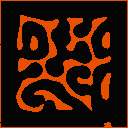

In [149]:
# Show the pattern at last.
img_pattern = Image.open(pjoin(dpath_images, "pattern_50000.png"))
img_pattern

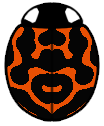

In [150]:
img_ladybird = Image.open(pjoin(dpath_images, "ladybird_50000.png"))
img_ladybird

In [151]:
# Model file
!ls {pjoin(dpath_output, "models")}

model_1.json


In [152]:
fpath_model = pjoin(dpath_output, "models", "model_1.json")
with open(fpath_model, "rt") as fin:
    model_dict = json.load(fin)

model_dict

{'model': 'LiawModel',
 'width': 128,
 'height': 128,
 'dx': 0.1,
 'thr_color': 0.5,
 'color_u': [5, 5, 5],
 'color_v': [231, 79, 3],
 'initializer': 'LiawInitializer',
 'u0': 2.0,
 'v0': 1.0,
 'n_init_pts': 25,
 'init_pts_0': [3, 65],
 'init_pts_1': [92, 53],
 'init_pts_2': [122, 0],
 'init_pts_3': [69, 33],
 'init_pts_4': [25, 76],
 'init_pts_5': [10, 77],
 'init_pts_6': [89, 39],
 'init_pts_7': [103, 58],
 'init_pts_8': [61, 13],
 'init_pts_9': [87, 44],
 'init_pts_10': [52, 65],
 'init_pts_11': [45, 103],
 'init_pts_12': [76, 78],
 'init_pts_13': [124, 8],
 'init_pts_14': [26, 73],
 'init_pts_15': [42, 66],
 'init_pts_16': [52, 36],
 'init_pts_17': [57, 31],
 'init_pts_18': [44, 0],
 'init_pts_19': [71, 112],
 'init_pts_20': [65, 54],
 'init_pts_21': [74, 123],
 'init_pts_22': [71, 18],
 'init_pts_23': [78, 104],
 'init_pts_24': [52, 79],
 'solver': 'EulerSolver',
 'dt': 0.01,
 'n_iters': 50000,
 'Du': 0.0005000000237487257,
 'Dv': 0.07500000298023224,
 'ru': 0.18000000715255737,
 

In [153]:
from lpf.visualization import merge_single_timeseries

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [160]:
!ls /usr/share/fonts/truetype/liberation

LiberationMono-BoldItalic.ttf	     LiberationSansNarrow-Bold.ttf
LiberationMono-Bold.ttf		     LiberationSansNarrow-Italic.ttf
LiberationMono-Italic.ttf	     LiberationSansNarrow-Regular.ttf
LiberationMono-Regular.ttf	     LiberationSans-Regular.ttf
LiberationSans-BoldItalic.ttf	     LiberationSerif-BoldItalic.ttf
LiberationSans-Bold.ttf		     LiberationSerif-Bold.ttf
LiberationSans-Italic.ttf	     LiberationSerif-Italic.ttf
LiberationSansNarrow-BoldItalic.ttf  LiberationSerif-Regular.ttf


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [163]:
from PIL import ImageFont


font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 10, encoding="UTF-8")

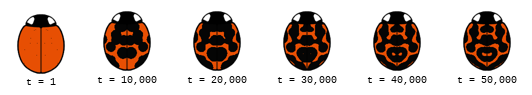

In [165]:
# Errors happen here because of font
# Visualize the temporal evolution of ladybird by merging images.
img_ladybirds = merge_single_timeseries(dpath_input=dpath_images,
                                        n_cols=10,
                                        infile_header="ladybird",
                                        ratio_resize=0.5,
                                        text_format="t = ",
                                        font_size=10,
                                        font=font,
                                        text_margin_ratio=.1)
img_ladybirds

In [166]:
img_ladybirds.save(pjoin(dpath_output, "output_ladybird.png"))

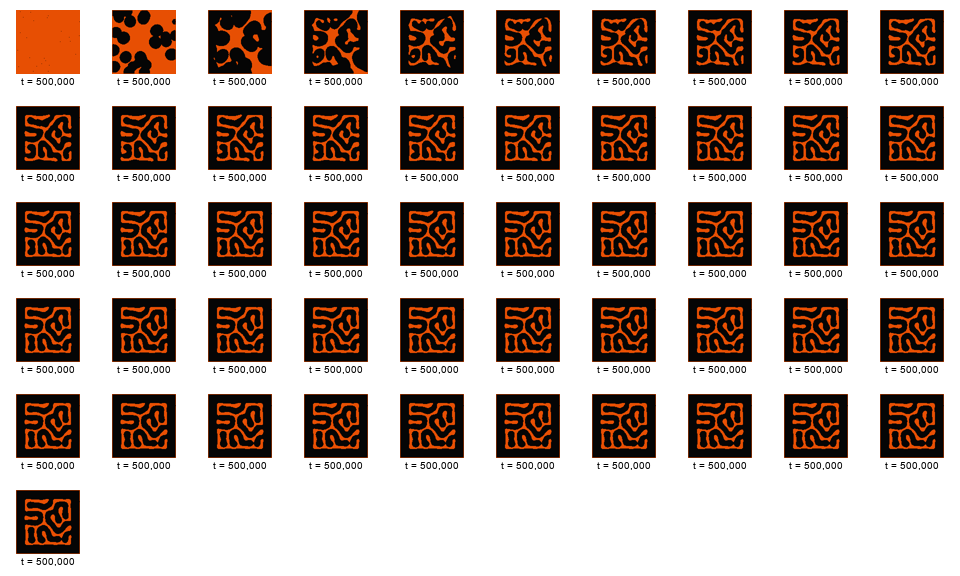

In [ ]:
img_patterns = merge_single_timeseries(dpath_input=dpath_images,
                                       n_cols=10,
                                       infile_header="pattern",
                                       ratio_resize=0.5,
                                       text_format="t = ",
                                       font_size=10,
                                       text_margin_ratio=.1)
img_patterns

In [ ]:
img_patterns.save(pjoin(dpath_output, "output_pattern.png"))

## Make a ladybug from parameters

From: tutorials/tutorial02_visualize_single_morph.ipynb

In [19]:
# might not be necessary
import os
os.chdir('/content/lpf_upper')

initializerfactory.py  __pycache__/
initializer.py         twocomponentconstantinitializer.py
__init__.py            twocomponentinitializer.py
liawinitializer.py


In [20]:
import os
import os.path as osp
from os.path import join as pjoin
import time
from datetime import datetime

import numpy as np
np.seterr(all='raise')

from lpf.initializers import LiawInitializer
from lpf.models import LiawModel
from lpf.solvers import EulerSolver, RungeKuttaSolver

In [21]:
batch_size = 1  # A single set of parameters
# TODO debug gpu option
device = "gpu"  # Device option: CPU or GPU

# Time parameters
dt = 0.01
n_iters = 10000 # 1000000

# Space parameters
dx = 0.1
width = 128
height = 128
shape = (height, width)

In [22]:
# Create the output directory.
str_now = datetime.now().strftime('%Y%m%d-%H%M%S')
dpath_output = pjoin(osp.abspath("./output"), "experiment_batch_%s" % (str_now))
os.makedirs(dpath_output, exist_ok=True)

In [23]:
# Create a dict for parameters.
param_dict =  {
 "u0": 1.9530066532565284,
 "v0": 2.3936837749803437,
 "Du": 0.000497858463742147,
 "Dv": 0.07796387325338522,
 "ru": 0.1829963268369453,
 "rv": 0.10001543043288767,
 "k": 0.15824185494975906,
 "su": 0.0004593283228100326,
 "sv": 0.021391505467616145,
 "mu": 0.09084717479481387
}

In [24]:
# In this example, we use 20 positions for initializing u with u0.
param_dict["init_pts_0"] = (20, 81)
param_dict["init_pts_1"] = (16, 27)
param_dict["init_pts_2"] = (85, 93)
param_dict["init_pts_3"] = (28, 39)
param_dict["init_pts_4"] = (119, 77)
param_dict["init_pts_5"] = (105, 39)
param_dict["init_pts_6"] = (68, 92)
param_dict["init_pts_7"] = (57, 46)
param_dict["init_pts_8"] = (53, 82)
param_dict["init_pts_9"] = (73, 78)
param_dict["init_pts_10"] = (25, 8)
param_dict["init_pts_11"] = (98, 23)
param_dict["init_pts_12"] = (74, 46)
param_dict["init_pts_13"] = (117, 45)
param_dict["init_pts_14"] = (58, 65)
param_dict["init_pts_15"] = (70, 75)
param_dict["init_pts_16"] = (71, 108)
param_dict["init_pts_17"] = (106, 36)
param_dict["init_pts_18"] = (125, 72)
param_dict["init_pts_19"] = (105, 84)

In [ ]:
param_dict

In [26]:
model_dicts = []
model_dicts.append(param_dict)

In [27]:
# Create the Liaw initializer.
initializer = LiawInitializer()
initializer.update(model_dicts)
params = LiawModel.parse_params(model_dicts)

In [28]:
# Create the Liaw model.
model = LiawModel(
    initializer=initializer,
    params=params,
    dx=dx,
    width=width,
    height=height,
    device=device
)

ValueError: ignored

In [ ]:
# Create the Euler solver.
solver = EulerSolver()

t_beg = time.time()

solver.solve(
    model=model,
    dt=dt,
    n_iters=n_iters,
    dpath_model=dpath_output,
    dpath_ladybird=dpath_output,
    dpath_pattern=dpath_output,
    verbose=0
)

t_end = time.time()

print("Elapsed time: %f sec." % (t_end - t_beg))

Elapsed time: 3.450543 sec.


In [ ]:
arr_color = model.colorize(thr_color=0.5)
img_ladybird, img_pattern = model.create_image(0, arr_color)

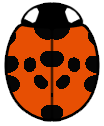

In [ ]:
img_ladybird

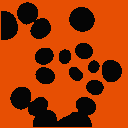

In [ ]:
img_pattern

In [ ]:
model.save_image(index=0,
                 fpath_ladybird=pjoin(dpath_output, "ladybird.png"),
                 fpath_pattern=pjoin(dpath_output, "pattern.png"),
                 arr_color=arr_color)

In [ ]:
# !ls {dpath_output}

ladybird.png
model_1
models
pattern.png


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x280f726afa0>
C:\Anaconda3\envs\lpf\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
C:\Anaconda3\envs\lpf\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)
C:\Anaconda3\envs\lpf\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
